**Predicting the price of bitcoin**

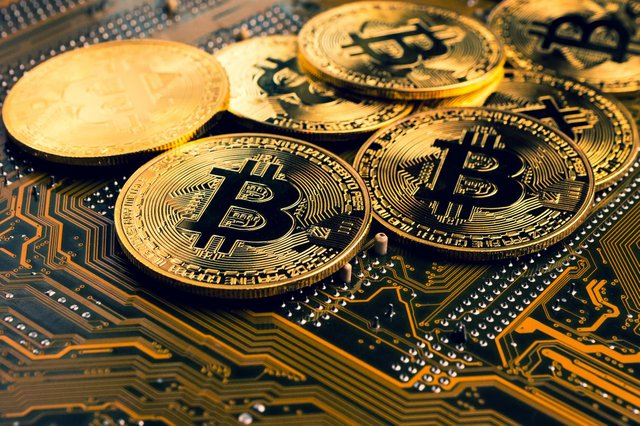

My research project will be based on the goal of learning and predicting the value of crypto currency. The praticular crypto currency that I will be using for this project will be Bitcoin. My goal is to predict the next 7 days values of the coin. I will see the entire KDD process to achieve my goal.

To begin with I Import all dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# I just brought this in to make it look cleaner. It is not necessary
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Data Selection**

I chose my project from the kaggle website. I found a data set that contained all recent cryptocurrency values. This was an interesting selection as the bitcoin csv could be replaced with an alternative coin and used to make a prediction on a future price.

Import the bitcoin CSV

In [ ]:
df = pd.read_csv('coin_Bitcoin.csv',parse_dates=True)

**Data preprocessing**

After choosing and importing my data my next objective was to begin the process of pre processing. My goals for this was to check for outliers and missing values as well as remove any columns that I didnt plan on using.

I first check the CSV values

In [ ]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


In [ ]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


I then check for null values.

In [ ]:
df.isna().sum()

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

There is no null values in this dataset. This is to be expected as Cryptocurrency datasets would be created with the intention of having complete and accurate data.

I now will remove any columns that I will not be using. For my example I want to know the closing value of the currency. As such I will remove the other columns

In [ ]:
df=df.drop(columns={"Name","Symbol","SNo","High","Low","Open","Volume","Marketcap"})

In [ ]:
df

,Date,Close
0,2013-04-29 23:59:59,144.539993
1,2013-04-30 23:59:59,139.000000
2,2013-05-01 23:59:59,116.989998
3,2013-05-02 23:59:59,105.209999
4,2013-05-03 23:59:59,97.750000
...,...,...
2986,2021-07-02 23:59:59,33897.048590
2987,2021-07-03 23:59:59,34668.548402
2988,2021-07-04 23:59:59,35287.779766
2989,2021-07-05 23:59:59,33746.002456


I also remove time from the 'Date' column. It wont effect what I intend to research so it will be better to have the date column just showing date values.

In [ ]:
df['Date'].head()

0    2013-04-29 23:59:59
1    2013-04-30 23:59:59
2    2013-05-01 23:59:59
3    2013-05-02 23:59:59
4    2013-05-03 23:59:59
Name: Date, dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [ ]:
df['Date'].head()

0    2013-04-29
1    2013-04-30
2    2013-05-01
3    2013-05-02
4    2013-05-03
Name: Date, dtype: object

I also set the Date column to be index. This will allow me to determine on what date the closing price was a good time to buy.

In [ ]:
df=df.set_index(['Date'])

I now simply plot what the closing price looks like on a graph.

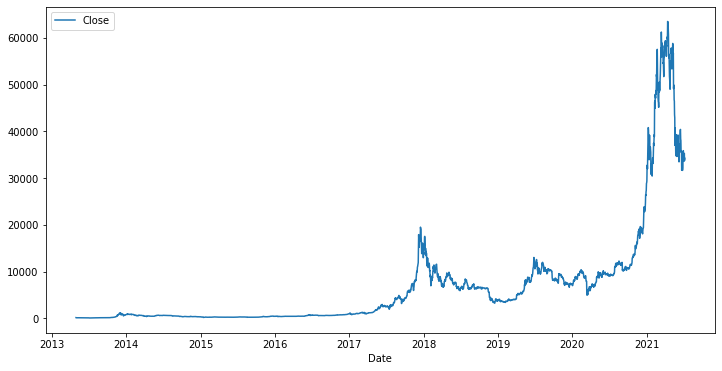

In [ ]:
df.plot(figsize=(12,6))

Looking at the graph it is quite obvious that the majority of the time prior to 2017 the coin had little to no value. I will print the median to check what its value is.

In [ ]:
df.median()

Close    2286.409912
dtype: float64

So the median is 2286.409912 so this becomes an issue when checking for outliers as values in the year 2021 are far beyond the median so these values will be predicted as outliers. As this is the case removing data such as this will not be wise as it removes the most current data values.

**Check for Outliers**

To determine outliers I used a box plot. The box plot graph is a good indication of how the values are spread out.

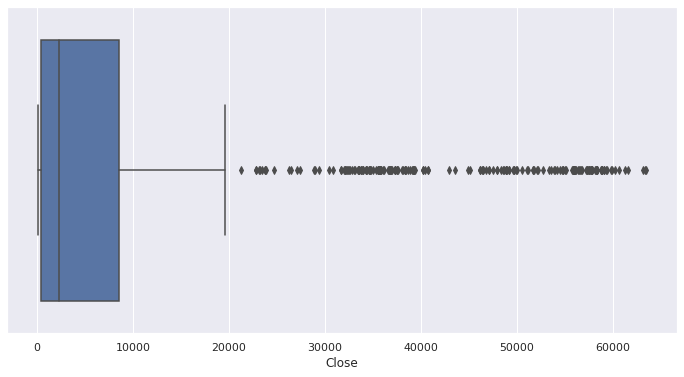

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.boxplot(x=df['Close'])

After analyising the previous graph and the box plot the values for the year 2021 could be classed as outliers as they are an abnormally large distance from the previous years values.

To remove outliers I get the values of both the lower and upper quartile of data, the 25th and 75th respectively, and from this I can calculate the interquartile range. The interquartile range is the middle 50%. I can use this value to then calculate the maximum and lower points of data and remove any outliers. 

The first quartile is the middle number between the smallest number (not the “minimum”) and the median of the dataset.

The third quartile is the middle value between the median and the highest value (not the “maximum”) of the dataset.

The minmum for a box plot is the first quartile **minus** 1.5 times the interquartile range while the maximum for the box plot is the third quartile **plus** 1.5 times the interquartile range.

The minimum is the lowest point of data excluding any outliers while the maximum is the highest point of data exluding any outliers. 

This information was gathered from [towardsdatascience.com](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

In [ ]:
Q1 = df['Close'].quantile(0.25)
print("The lower quartile value is "+str(Q1))
Q3 = df['Close'].quantile(0.75)
print("The upper quartile value is "+str(Q3))
interquartileRange = Q3 - Q1
print("The interquartile range is "+str(interquartileRange))

filter = (df['Close'] >= Q1 - 1.5*interquartileRange) & (df['Close'] <= Q3 + 1.5*interquartileRange)
#The minimum for a box plot is Q1 -1.5*interquartileRange while the maximum for the box plot is Q3 + 1.5*interquartileRange
#The minimum is the lowest point of data excluding any outliers while the maximum is the highest point of data exluding any outliers.

#I added a variable to show how the predictors data gets skewed with outliers later in the notebook.
dfFullValues=df

# this is how I would filter the data
df=df.loc[filter] 

The lower quartile value is 430.5694885253906
The upper quartile value is 8576.238715335
The interquartile range is 8145.6692268096085


The new box plot looks as follows.

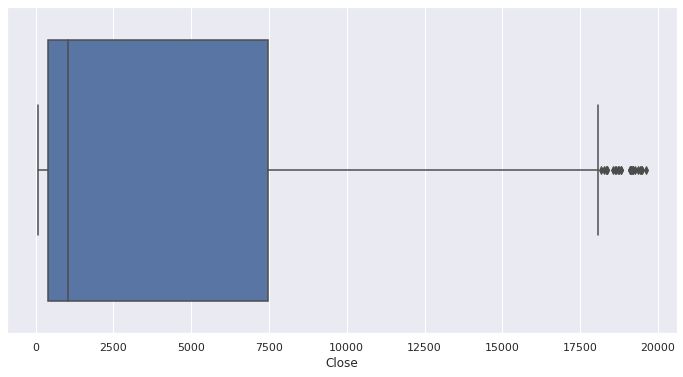

In [ ]:
sns.boxplot(x=df['Close'])

In [ ]:
df

,Close
Date,
2013-04-29,144.539993
2013-04-30,139.000000
2013-05-01,116.989998
2013-05-02,105.209999
2013-05-03,97.750000
...,...
2020-12-11,18058.903347
2020-12-12,18803.656870
2020-12-13,19142.382534


looking at the data the values beyond 15-12-2020 have been removed. This is because these values are beyond the maximum of the interquartile range. I will now plot and see the new graph.

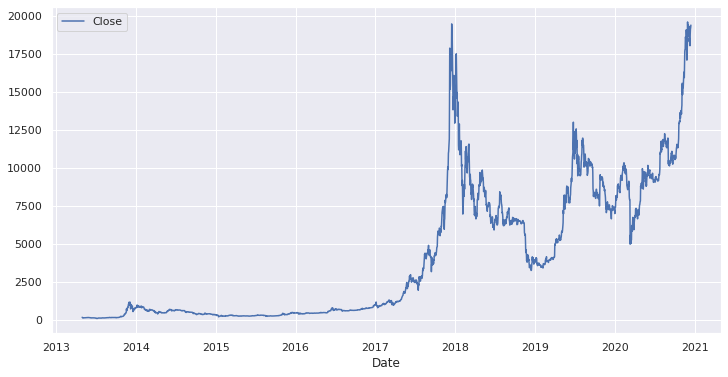

In [ ]:
df.plot(figsize=(12,6))

This does cut off the import piece of data. **The most recent values**. I will use the dataframe with the most recent values later to make a prediction as this is essential data for the most current information and does not need to be removed as outliers.

My first plan is to check the values based on monthly data. This is not practical as people wish to know data information on stocks down to the nearest second. However I will be doing this for research purposes. I now group the data so that it shows the first value of the month for every month. I do this to get a monthly prediction of the close price per month.

In [ ]:
df=df.groupby(pd.DatetimeIndex(df.index).to_period('M')).nth(0)

In [ ]:
df

,Close
Date,
2013-04,144.539993
2013-05,116.989998
2013-06,129.300003
2013-07,88.050003
2013-08,104.000000
...,...
2020-08,11759.592771
2020-09,11970.478741
2020-10,10619.451908


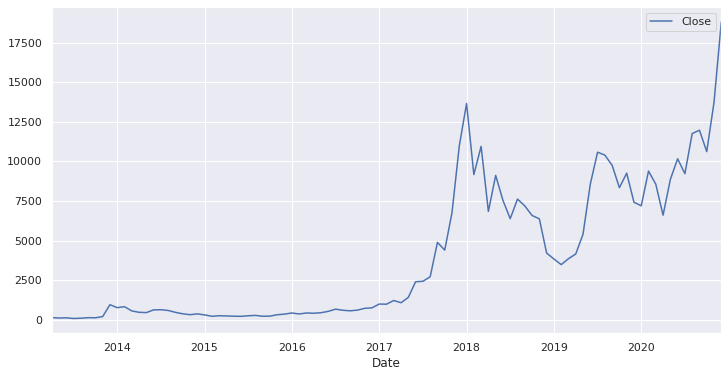

In [ ]:
df.plot(figsize=(12,6))

Observing the new graph It is similar to the previous graph however it is much more smooth. This is because there isnt as much data points to plot however the trend will remain the same.

Next I check for seasonality to see if there is any pattern in the data. I use a predefined method to generate a decomposed model object called seasonal_decompose. According to the website [statsmodels.org](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) "The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.". The function of this object is to generate 4 graphs to determine patterns in time series data. To do this i had to convert my dataframe index from a period index to a dateTimeIndex as the seasonal decompose object requires this format in order to generate the data. So rather than having the data in the format "2013-04" it will now be "2013-04-01".

In [ ]:
df.index

PeriodIndex(['2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09',
             '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03',
             '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09',
             '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03',
             '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09',
             '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03',
             '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09',
             '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03',
             '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09',
             '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
             '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09',
             '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03',
             '2019-04', '2019-05', '2019-06', '2019-

In [ ]:
df.index = df.index.to_timestamp()

In [ ]:
df.index

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
      

In [ ]:
#I also just adjust the dataframe with the outliers because it keeps the 2 dataframes the same for comparrison later.
dfAdjustedFullValues=dfFullValues.groupby(pd.DatetimeIndex(dfFullValues.index).to_period('M')).nth(0)
dfAdjustedFullValues.index = dfAdjustedFullValues.index.to_timestamp()

In [ ]:
results = seasonal_decompose(df['Close'])

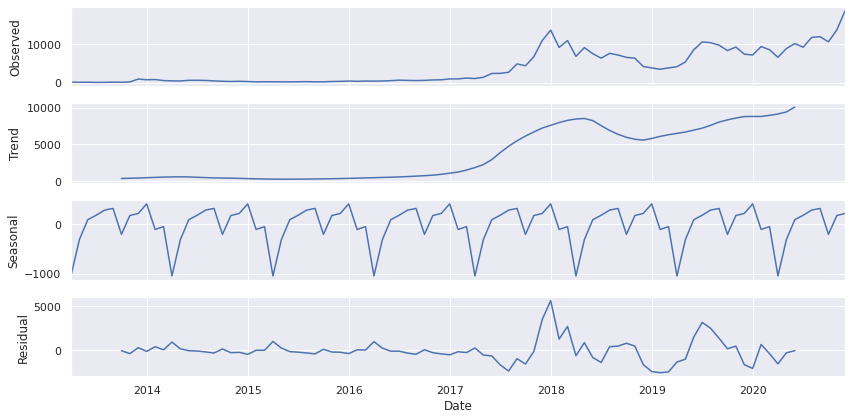

In [ ]:
results.plot();

Looking at the graphs presented from the seasonal decompose function I can gather a bit of information. 

*   The observed graph is the graph of the market cap value (This graph is the same as what I printed earlier in the page)
*   The trend graph shows the general direction the price of the coin is heading towards
*   The seasonality graph shows regular and predictable changes that recur every year. Seasonality is calculated by removing the trend from the observed graph. This is a the most interesting of the four graphs as it shows me that there is definitely a pattern from this graph. 
*   The residual graph shows a measure of how far away a point is vertically from the regression line. The residual graph is calculated by subtracting seasonal and trend components from the observed componenet.






















































With some information gathered on my dataframe and some basic levels of preprocessing completed, my next task was to begin the transformation aspect of the project.

**Transformation**

I will now split the dataset into a training and a test set. The first dataset(Training) will have all the values of bitcoin except the last 12 months. The second dataset (Test) will have the last 12 months. I will calculate the last 12 months of the data using all previous data entries to determine an accurate prediction. I simply cant use the training data to make a prediction because the model already knows this information. The goal is to test to see if the model has truely learnt how to predict new values and not just memorise previously learnt values. This is why I retain a seperate amount of values to test against the trained data.

In [ ]:
len(df)

93

In [ ]:
predictionInMonths=12

training = df.iloc[:len(df)-predictionInMonths]
testData = df.iloc[len(df)-predictionInMonths:]

In [ ]:
len(training)

81

In [ ]:
len(testData)

12

In [ ]:
training

,Close
Date,
2013-04-01,144.539993
2013-05-01,116.989998
2013-06-01,129.300003
2013-07-01,88.050003
2013-08-01,104.000000
...,...
2019-08-01,10399.669423
2019-09-01,9757.970318
2019-10-01,8343.276681


Using a scaler method the data is converted into values from 0-1 which will normalise the data and allows values that can be used to make a more accurate prediction. This will allow data with diffirent ranges of magnitude to be taken into account( The start of bitcoins value was significantly less than the current value so this is why i need the scaler to the scale the difference)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaledTrainingData = training.values
scaledTrainingData = scaler.fit_transform(scaledTrainingData)

The scaler object presents me with normalised data that is easier to work with. an example of the scaled data can be shown below. The training data is unscaled denormalised values while the scaledTrainingData is the normalised version that has values ranging from 0-1

In [ ]:
training['Close'][:10]

Date
2013-04-01    144.539993
2013-05-01    116.989998
2013-06-01    129.300003
2013-07-01     88.050003
2013-08-01    104.000000
2013-09-01    138.339996
2013-10-01    132.179993
2013-11-01    206.179993
2013-12-01    955.849976
2014-01-01    771.400024
Freq: MS, Name: Close, dtype: float64

In [ ]:
scaledTrainingData[:10]

array([[0.00416312],
       [0.00213278],
       [0.00303998],
       [0.        ],
       [0.00117546],
       [0.0037062 ],
       [0.00325223],
       [0.00870578],
       [0.06395389],
       [0.05036056]])

I then setup training values that I will use fit to the LSTM model. I will also reshape the Xtrain data so that it will have the all the rows that should be in Xtrain as well as 1 column and 1 feature.

In [ ]:
Xtrain = scaledTrainingData[0:len(scaledTrainingData)-1]
Ytrain = scaledTrainingData[1:len(scaledTrainingData)]
Xtrain = np.reshape(Xtrain, (len(Xtrain),1,1))
Xtrain.shape

(80, 1, 1)

Now that I have transformed the data my next task is to begin data mining.

**Data mining**

The next task is to create a LSTM model. LSTM is a recurrent nerual network. In comparrison to other nerual networks LSTM deals with sequences of data. I learnt of LSTM models from a [Youtube](https://www.youtube.com/watch?v=S8tpSG6Q2H0&t=2s&ab_channel=NachiketaHebbar) channel. In the video the creator used a diffirent activation function as well as a time series predictor. This would not generate the results that I wanted from my model so I modified the LSTM model to fit my data. I will use the keras model which will have an input layer which will be the LSTM layer and an output layer which will specify the shape of the expected output. I will first define that the model will add layers sequetially.

In [ ]:
model = Sequential()

Next I add a LSTM layer to the model. The LSTM layer takes a dimensionality parameter which will be 4 units. An activation parameter of "sigmoid" is used. Sigmoid is a non-linear activation function. Sigmoid maintains the values between 0 and 1. I will also give it the shape of the object.

In [ ]:
model.add(LSTM(4, activation='sigmoid', input_shape=(None,1)))

Next I will add the ouptut layer. Dense is most commonly used in the keras model. In my model I expect my model to predict a single output value for each month so I give the number 1 as a parameter.

In [ ]:
model.add(Dense(1))

I then compile the model.I sent my arguments to calculate my loss as the mean squared error and i use the adam optimizer algorithim. This algorithim is used for training deep learning models.

In [ ]:
model.compile(optimizer='adam', loss='mse')

I can now generate a summary of the model. This will give me an overview as to what my model should look like.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


I now fit the model with the X and Y train and run it for 100 epochs. An epoch is an event in time. So each epoch will be a new iteration that the model can learn the expected outcome. After an unspecified number of epochs the model will become familar with the data and will generate a more accurate prediction. The unspecified number depends on the quantity of data supplied to the LSTM model.

In [ ]:
history=model.fit(Xtrain, Ytrain,batch_size=1, epochs=100)

Epoch 1/100
80/80 [==============================] - 3s 3ms/step - loss: 0.1062
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0901
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0868
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0835
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0821
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 8/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 11/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 12/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 13/100
80/80 [=================

I can now generate a graph to show how the model learned the data. I simply retrieve the loss per epoch fron the history of the model and then plot it on a graph.

In [ ]:
lossPerEpoch=history.history['loss']

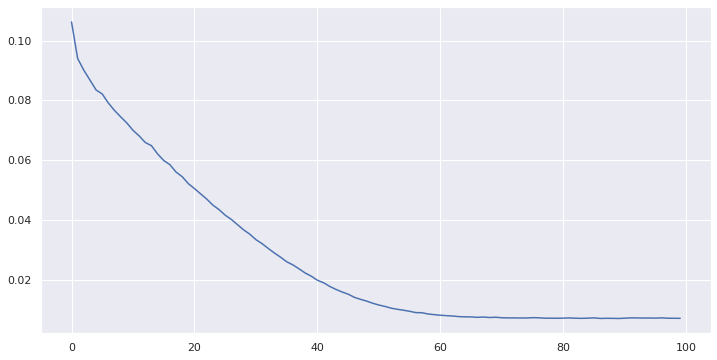

In [ ]:
plt.plot(range(len(lossPerEpoch)), lossPerEpoch)

It can be determined from the graph that after around 40 epochs the model was making fewer mistakes and was becoming more familar and accurate with its prediction. (as this is a calculated prediction this graph will change each time it is run )

Now my model is trained with the training data I can now use this model to make a prediction. I can now take the last 12 values from the training set and make a prediction with the model and compare this with the the test data to evaluate the accuarcy of the model

Next i reshape the data so that I can make a prediction. I reshape the testData and store it in a variable called inputs. The initial shape of the data is a 2D array with 12 rows and 1 column. I need to scale the testData (now called inputs) and then I reshape that data to a 3D array with 12 rows, 1 column and 1 feature

In [ ]:
inputs = np.reshape(testData,(len(testData),1))
print(inputs.shape)
inputs = scaler.transform(inputs)
print('\n'+str(inputs))
inputs = np.reshape(inputs, (len(inputs),1,1))
print('\n'+str(inputs.shape))

(12, 1)

[[0.52413926]
 [0.68573383]
 [0.62453462]
 [0.48040785]
 [0.64681404]
 [0.74280393]
 [0.67360708]
 [0.86015282]
 [0.87569439]
 [0.77612833]
 [1.00588907]
 [1.37922774]]

(12, 1, 1)


Finally I can make a prediction. I simply use the model to predict the inputs values. This will give me the scaled predicted price value of each value in the testData. I finally reverse the scaling process to give me the actual price values.

In [ ]:
predictedPrice =model.predict(inputs)
predictedPrice = scaler.inverse_transform(predictedPrice)

I now add the predictedPrice to a new column called predictions in the testData dataframe.

In [ ]:
testData['Predictions'] = predictedPrice

In [ ]:
testData

,Close,Predictions
Date,,
2020-01-01,7200.174393,7293.176758
2020-02-01,9392.875368,9225.471680
2020-03-01,8562.454050,8513.642578
2020-04-01,6606.776268,6742.683105
2020-05-01,8864.766808,8775.717773
2020-06-01,10167.268101,9865.872070
2020-07-01,9228.325590,9086.450195
2020-08-01,11759.592771,11108.490234
2020-09-01,11970.478741,11265.400391


So now I have mined the data and retrieved some information. The next step of my process is to visualise the Data

**Visualise and Interpret the data**

Printing the dataframe shows me the original close price and the predicted price values from my model. From this Data I can see that my models estimation is quite close to the original values. To make this more clear I can simply plot a graph and overlay the 2 values.

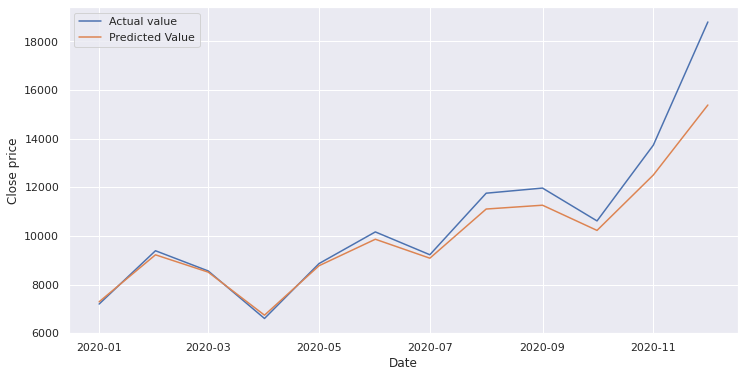

In [ ]:
plt.plot(testData['Close'],label="Actual value")
plt.plot(testData['Predictions'],label="Predicted Value")

plt.ylabel('Close price')
plt.xlabel('Date')
plt.legend()

From evaluating the graph I can determine that my model has made a realitvely accurate prediction. The values are quite similar at the start. After that the values shape begins to deteriorate a small bit. This tells me that values in a shorter time frame are more accurate. This is logical as it is easier to predict values for the next month rather than predicting values for a years time. The longer the graph is the more difficult it becomes to predict.

If I had trusted that my model was accurate and purchaced my stock on 04-2020 then I would have made a profit If I held that stock. For a few months.

I created a function to repeat what I just did. I could have wrote the function to begin with and only wrote it ounce but I wanted to explain the process. So now with this function I can pass in any data frame ,the time frame to predict as well as the amount of epochs required to be run with the model and I will get a graph on how the models prediction of the close price value.

In [ ]:
def LSTMPredictor(df,predictionTime,epoch):
  #make training data
  training = df.iloc[:len(df)-predictionTime]

  #scale the data
  scaledTrainingData = training.values
  scaledTrainingData = scaler.fit_transform(scaledTrainingData)

  #setup training values and shape
  Xtrain = scaledTrainingData[0:len(scaledTrainingData)-1]
  Ytrain = scaledTrainingData[1:len(scaledTrainingData)]
  Xtrain = np.reshape(Xtrain, (len(Xtrain),1,1))

  #create model (the only diffirence here is that I used verbose on the fir. All this does is silence the ouput messages. Just makes it look cleaner)
  model = Sequential()
  model.add(LSTM(4, activation='sigmoid', input_shape=(None,1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  history=model.fit(Xtrain, Ytrain,batch_size=1, epochs=epoch,verbose=0)

  #create test data
  testData = df.iloc[len(df)-predictionTime:]
  inputs = np.reshape(testData,(len(testData),1))
  inputs = scaler.transform(inputs)
  inputs = np.reshape(inputs, (len(inputs),1,1))

  #predict price
  predictedPrice =model.predict(inputs)
  predictedPrice = scaler.inverse_transform(predictedPrice)
  
  #add to dataframe
  testData['Predictions'] = predictedPrice

  plt.plot(testData['Close'],label="Actual value")
  plt.plot(testData['Predictions'],label="Predicted Value")

  plt.ylabel('Close price')
  plt.xlabel('Date')
  plt.legend()

So I will test it. I will pass it the dataframe containing the outliers.

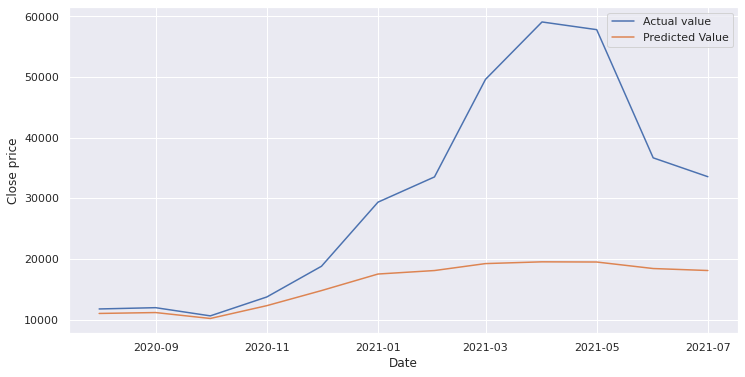

In [ ]:
LSTMPredictor(dfAdjustedFullValues,12,100)

So this is an interesting graph. In comparison to the graph with the most recent data removed the predicted values begins to become very inaccurate. This is because It cannot predict the extreme change in its price. Because of the sudden spike in the stocks price the data is far beyond what the model has seen previously so it fails to predict these new values. However one thing to take note is that although the predictor does not reach the same actual values it does however have the same sort of rising and falling curve.

So what happens if I give it values for every day and check the last 30 days.

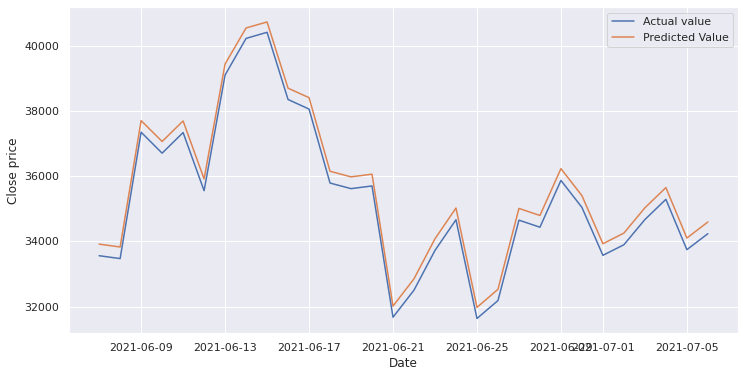

In [ ]:
LSTMPredictor(dfFullValues,30,100)

Because I have given the model every day value in the data set it takes alot longer to run. Having more values to predict from however gives the model a higher possibility of predicting a more accurate outcome.

The ultimate goal is to predict future prices. So what if we could use the day close price and predict the next weeks close prices. **Should I buy today?will the stock go up by the end of the week?**

**Future Prediction**

To begin my future prediction I reindex my dataframe and include the next 7 days. To do this I take the create a new date time index and take the last day of the month and I add 7 more days (so originally I will have 8 days because of the last day included)

In [ ]:
forecastedDates = pd.date_range(dfFullValues.index[-1],periods=8)

In [ ]:
forecastedDates

DatetimeIndex(['2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09',
               '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13'],
              dtype='datetime64[ns]', freq='D')

Now that I have my days setup I will rebuild my LSTM model. I will just use values for the last 200 days to train my model as The future days that I want to predict will follow a similar trend (There is no point giving it values from 2013 because the value wont just suddenly reduce to those sort of prices)

In [ ]:
#modified predictor for forecasting
training = dfFullValues.iloc[-200:]

#scale the data
scaledTrainingData = training.values
scaledTrainingData = scaler.fit_transform(scaledTrainingData)

#setup training values and shape
Xtrain = scaledTrainingData[0:len(scaledTrainingData)-1]
Ytrain = scaledTrainingData[1:len(scaledTrainingData)]
Xtrain = np.reshape(Xtrain, (len(Xtrain),1,1))

#create model again i used verbose to hide all the output messages. It was just my preference
model = Sequential()
model.add(LSTM(4, activation='sigmoid', input_shape=(None,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history=model.fit(Xtrain, Ytrain,batch_size=1, epochs=100,verbose=0)

I then make a prediction using the trained value and calculated the next 8 days (The first day included)

In [ ]:
forecast= model.predict(Xtrain[-8:])

I then just simply use the reverse transform

In [ ]:
forecast=scaler.inverse_transform(forecast)

I just wanted to see what the list looks like. Something I took note was because of the way I set up the array the values were added in reverse order. So the last value in the forecast array is the prediction for the 2021-07-06. 

In [ ]:
forecast

array([[35131.81 ],
       [36595.613],
       [35750.668],
       [34253.668],
       [34584.344],
       [35370.695],
       [36002.867],
       [34430.586]], dtype=float32)

In [ ]:
firstForecast=model.predict(Xtrain[-1:])
firstForecast=scaler.inverse_transform(firstForecast)
firstForecast

array([[34430.586]], dtype=float32)

I simply re made a prediction to show that the values were added sequentially. This would mean that when creating a new data frame I would have to add the values in reverse order. To align with the correct dates.

So I created a new Data frame with the predicted dates and predicted values. The forecast[::-1] is how i added the values in reverse order. This code was taken from [thispointer.com](https://thispointer.com/drop-first-row-of-pandas-dataframe-3-ways/)

In [ ]:
dfForecastValues=pd.DataFrame(index=forecastedDates)

dfForecastValues['Close']=forecast[::-1]

I now simply wanted to view my results.

In [ ]:
dfForecastValues

,Close
2021-07-06,34430.585938
2021-07-07,36002.867188
2021-07-08,35370.695312
2021-07-09,34584.343750
2021-07-10,34253.667969
2021-07-11,35750.667969
2021-07-12,36595.613281
2021-07-13,35131.808594


Now that I have a Dataframe established I wanted to remove the first column in the table as I already know what the value for the 06-07-2021 is.dfForecastValues.iloc[1: , :] will contain all values after the first row

In [ ]:
dfForecastValues = dfForecastValues.iloc[1: , :]

In [ ]:
dfForecastValues

,Close
2021-07-07,36002.867188
2021-07-08,35370.695312
2021-07-09,34584.343750
2021-07-10,34253.667969
2021-07-11,35750.667969
2021-07-12,36595.613281
2021-07-13,35131.808594


Now that I have a forecasted dataframe for days after my original data frame I will add this to the original dataframe.

In [ ]:
dfFullValues=dfFullValues.append(dfForecastValues)

In [ ]:
dfFullValues['Close'].tail(10)

2021-07-04             35287.779766
2021-07-05             33746.002456
2021-07-06             34235.193451
2021-07-07 00:00:00    36002.867188
2021-07-08 00:00:00    35370.695312
2021-07-09 00:00:00    34584.343750
2021-07-10 00:00:00    34253.667969
2021-07-11 00:00:00    35750.667969
2021-07-12 00:00:00    36595.613281
2021-07-13 00:00:00    35131.808594
Name: Close, dtype: float64

Finally I will plot these new values on a graph. I created a graph function to do this. I did this so I could display any values within the past number of days and pass this as a parameter to the function. This allowed me to essentially zoom in and out so I could view my predictions on the graph.

In [ ]:
def finalPlot(valuesToBeShown):
  plt.plot(dfFullValues['Close'][-valuesToBeShown:],label="Actual value")

  #for all the new values I selected their location and i
  plt.plot(dfFullValues.loc[pd.to_datetime("2021-07-06").date():], color='orange', label="Predicted value")

  plt.ylabel('Close price')
  plt.xlabel('Date')
  plt.legend()

**Knowledge**

This is what the Final prediction looks like with the last 100 values included

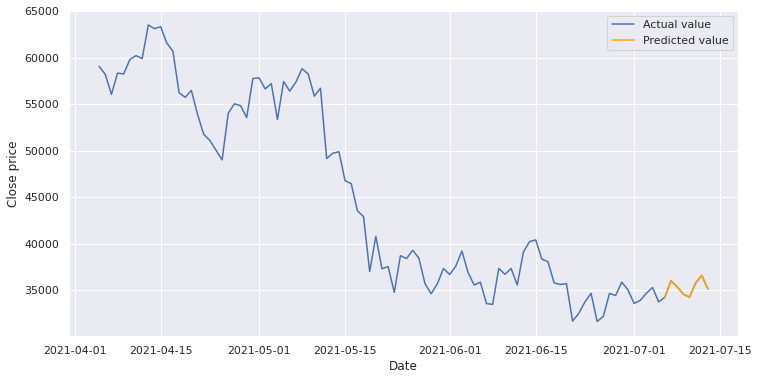

In [ ]:
finalPlot(100)

This is what the graph looks like over the next 7 days. If the graph closing value trends like this then the closing value will be low on the 10-07-2021 this would mean that this would be an ideal opportunity to purchase stocks at this time as by the 12-07-21 the value is expeted to rise again.

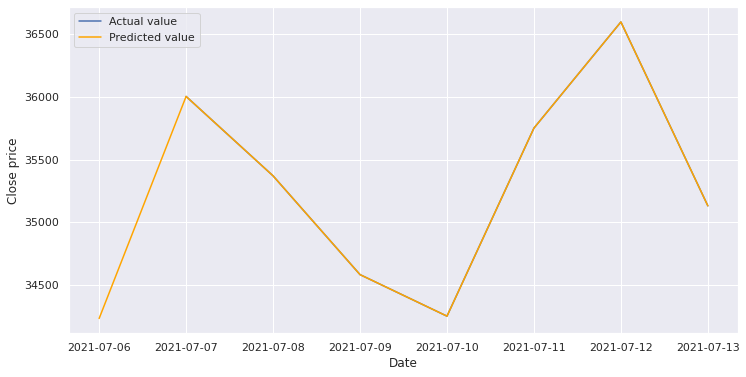

In [ ]:
finalPlot(7)

**Conclusion**

After going through the entire KDD process I have learnt alot about the steps required to analise data. The model that I have created took data that was previously available and made a prediction based on previous values. This is very facinating prospect as this knowledge obtained from this research could be used to purchase stocks and generate a profit.